# Machine Learning with Hyperparameter Optimization in DASK

Continuation from the earlier notebook...

In [1]:
import os
from os.path import isfile, join

from time import time

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio
import rasterio.features
import rasterio.warp
import geojson

import matplotlib.pyplot as plt
import seaborn as sns
import folium
import shapely.geometry

In [2]:
import warnings
warnings.filterwarnings('ignore')
# ignoring warnings to keep the jyupter notebook clutter free

In [3]:
directory_path = '/data/shared/Big-Geodata-Processing-2023-1A/Exercise3/EuroSAT_MS/'

In [4]:
# function to get all details of the image by reading the each image only once

def get_all(filename):
    with rasterio.open(filename) as dataset:

        # CENTROID
        # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()

        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            geom = rasterio.warp.transform_geom(
                dataset.crs, 'EPSG:4326', geom, precision=6)
            ls = list(geojson.utils.coords(geom))
            x = []
            y = []
            for row in ls:
                x.append(row[0])
                y.append(row[1])
            cent = [min(y)+(max(y)-min(y))/2,min(x)+(max(x)-min(x))/2]

        # BAND STATS 
        # Selected bands are R, G, B, NIR, SWIR2 to reduce dimentionality and avoid overfitting

        band_mean = []
        band_median = []
        band_min = []
        band_max = []
        band_range = []

        bands_selected = [2,3,4,8,13]
        for band in bands_selected:
            band_values = dataset.read(band).astype('float64')
            band_mean.append(round(np.mean(band_values), 4))
            band_median.append(round(np.median(band_values), 4))
            b_min = np.min(band_values)
            b_max = np.max(band_values)
            band_min.append(round(b_min, 4))
            band_max.append(round(b_max, 4))
            band_range.append(round((b_max - b_min), 4))


        # BAND INDICES
        # https://ieeexplore.ieee.org/abstract/document/8736785
        # The median values of calculated indices are used.
        # Choosing median over mean as we want the indices value of manjority of the image.
        # indices choosen based on available classes

        indices = []

        b_green = dataset.read(3).astype('float64')
        b_red = dataset.read(4).astype('float64')
        b_nir = dataset.read(8).astype('float64')
        b_swir2 = dataset.read(13).astype('float64')

        np.seterr(divide='ignore', invalid='ignore')

        # NDVI and SAVI for forested and crop area (L = 0.5 corresponding to moderate canopy)
        b_ndvi = (b_nir - b_red) / (b_nir + b_red)
        b_savi = ((b_nir - b_red) / (b_nir + b_red + 0.5))*(1.5)
        indices.append(round(np.median(b_ndvi), 4))
        indices.append(round(np.median(b_savi), 4))

        # NDWI for water related classes
        b_ndwi = (b_green - b_nir) / (b_green + b_nir)
        indices.append(round(np.median(b_ndwi), 4))

        # NDBI for built up surfaces
        b_ndbi = (b_swir2 - b_nir) / (b_swir2 + b_nir)
        indices.append(round(np.median(b_ndbi), 4))


    return cent, band_mean, band_median, band_min, band_max, band_range, indices

In [5]:
subfolders = [ f.path for f in os.scandir(directory_path) if f.is_dir() ]

In [6]:
%%time

df = pd.DataFrame(columns=["Lat", "Lon", "Class"])
bands_selected = [2,3,4,8,13]
# Selected bands are R, G, B, NIR, SWIR2 to reduce dimentionality and avoid overfitting

for i in range(len(subfolders)):
    image_path = subfolders[i]
    class_name = os.path.basename(image_path)
    all_images = [f for f in os.listdir(image_path) if os.path.isfile(join(image_path, f))]
    print(class_name,len(all_images))
    for j in range(len(all_images)):
        cent, band_mean, band_median, band_min, band_max, band_range, indices  = get_all(image_path+'/'+all_images[j])

        new_row = pd.DataFrame({
            "Lat": cent[0], 
            "Lon": cent[1], 
            "Class": class_name,
            **{f"Band_{value}_mean": band_mean[k] for k, value in enumerate(bands_selected)},
            **{f"Band_{value}_median": band_median[k] for k, value in enumerate(bands_selected)},
            **{f"Band_{value}_min": band_min[k] for k, value in enumerate(bands_selected)},
            **{f"Band_{value}_max": band_max[k] for k, value in enumerate(bands_selected)},
            **{f"Band_{value}_range": band_range[k] for k, value in enumerate(bands_selected)},
            "I_NDVI_median": indices[0],
            "I_SAVI_median": indices[1],
            "I_NDWI_median": indices[2],
            "I_NDBI_median": indices[3]
        }, index=[0])
        df = pd.concat([df, new_row], ignore_index=True)


Residential 3000
Pasture 2000
SeaLake 3000
HerbaceousVegetation 3000
Forest 3000
Industrial 2500
River 2500
PermanentCrop 2500
AnnualCrop 3000
Highway 2500
CPU times: user 3min 22s, sys: 24.3 s, total: 3min 46s
Wall time: 4min 32s


From the above printed values, it can be noted that all classes of LULC have 2500 - 3000 points. This almost even distribution among classes is helpful for training the machine learning model in an unbiased manner.

In [7]:
df

,Lat,Lon,Class,Band_2_mean,Band_3_mean,Band_4_mean,Band_8_mean,Band_13_mean,Band_2_median,Band_3_median,...,Band_13_max,Band_2_range,Band_3_range,Band_4_range,Band_8_range,Band_13_range,I_NDVI_median,I_SAVI_median,I_NDWI_median,I_NDBI_median
0,51.636699,0.409756,Residential,1087.1743,901.1694,791.6636,1622.4224,1809.6243,1074.0,891.0,...,4075.0,1052.0,1565.0,2572.0,3399.0,2876.0,0.3176,0.4763,-0.2604,0.0612
1,43.677658,7.113914,Residential,1166.1226,1116.6089,1046.3782,2491.4802,2831.2668,1122.0,1067.0,...,3865.0,1735.0,2244.0,2896.0,3360.0,1878.0,0.4197,0.6295,-0.3880,0.0649
2,51.630671,-0.732539,Residential,1051.7507,984.2322,836.3401,2382.4775,2706.3179,1043.0,977.0,...,4424.0,1490.0,1336.0,1919.0,3853.0,2774.0,0.4403,0.6603,-0.3857,0.0703
3,52.333434,8.017260,Residential,1042.3748,868.2256,780.4990,1833.2454,2098.9531,1030.0,861.0,...,4799.0,1066.0,1108.0,1545.0,4247.0,3468.0,0.3547,0.5320,-0.3091,0.0697
4,43.730154,7.160103,Residential,1042.5291,970.1846,869.0532,2418.7869,2736.0049,975.0,894.0,...,3738.0,4882.0,5107.0,5396.0,9647.0,1981.0,0.5014,0.7520,-0.4478,0.0620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,49.216428,16.408736,Highway,1181.4778,1205.3447,1209.0364,2599.4766,2952.5251,1036.0,1140.0,...,3882.0,3825.0,3992.0,4717.0,4028.0,2065.0,0.4394,0.6590,-0.4206,0.0701
26996,49.082481,2.728486,Highway,1367.1580,1380.7993,1751.2991,2728.2957,3272.2312,1396.0,1438.0,...,3684.0,1609.0,1622.0,2100.0,2231.0,1881.0,0.2012,0.3017,-0.3286,0.0928
26997,37.763857,-3.719099,Highway,1755.2141,1903.7380,2208.5732,3079.9624,3461.2805,1745.0,1895.5,...,4453.0,1469.0,1859.0,2414.0,2709.0,2363.0,0.1638,0.2457,-0.2395,0.0570
26998,50.744405,4.544050,Highway,1004.7075,952.9724,816.0300,2661.9939,3059.2334,994.0,957.0,...,5095.0,866.0,1159.0,1542.0,3627.0,3335.0,0.5813,0.8719,-0.4855,0.0682


Managing null values before machine learning.

In [8]:
if df.isna().any().any():
    print("The DataFrame contains null values.")
else:
    print("The DataFrame does not contain null values.")

The DataFrame contains null values.


In [9]:
# Checking which columns have null
null_counts = df.isna().sum()
# null_counts

In [10]:
## Cheacking which rows have null
rows_with_null = df[df.isna().any(axis=1)].index
rows_with_null

Int64Index([656], dtype='int64')

In [11]:
# df.iloc[656]

In [11]:
# Manually calculating one null value with band median values

row_index = 656
df.at[row_index, 'I_NDVI_median'] = ((df.at[row_index, 'Band_8_median'] - df.at[row_index, 'Band_4_median']) / 
                                     (df.at[row_index, 'Band_8_median'] + df.at[row_index, 'Band_4_median']))

In [12]:
if df.isna().any().any():
    print("The DataFrame contains null values.")
else:
    print("The DataFrame does not contain null values.")

The DataFrame does not contain null values.


The DataFrame can now be used for training maching learning model with selected features.

### Visualising image points with folium

In [13]:
llc = ['Lat', 'Lon', 'Class']

# Keep only the required columns
df_llc = df[llc].copy()

In [14]:
gdf_ImageCentroids = gpd.GeoDataFrame(
    df_llc,
    geometry=gpd.points_from_xy(df_llc['Lon'], df_llc['Lat']),
    crs='EPSG:4326'
)

# gdf_ImageCentroids

gdf_ImageCentroids_random5000 = gdf_ImageCentroids.sample(n=5000, random_state=42)
# randomly sampling 5000 rows to plot using folium

In [15]:
gdf_ImageCentroids_random5000.explore(column = 'Class',zoom_start=3.5)

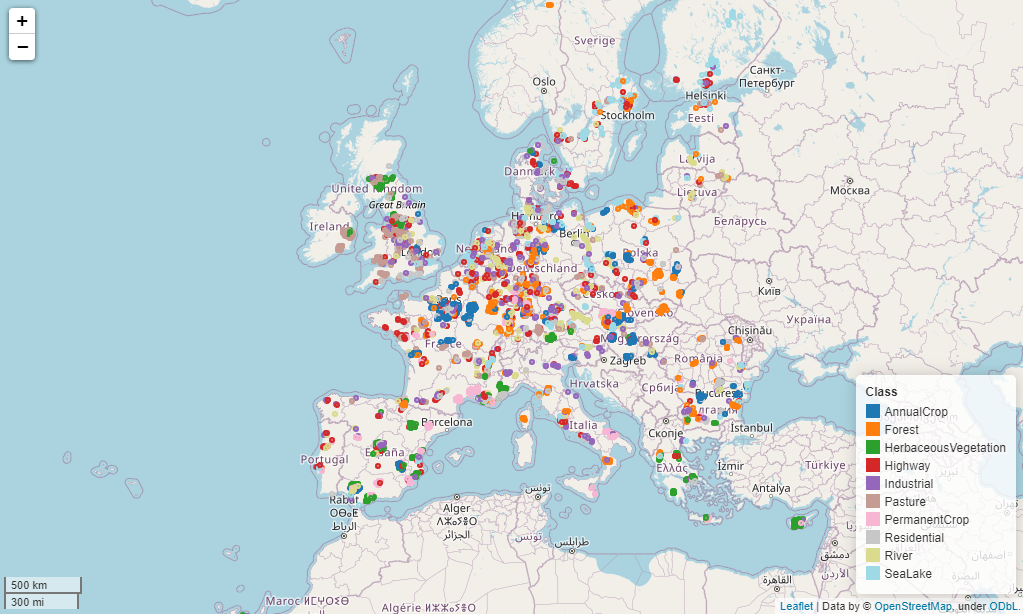

From the above visualisation it can be seen that all the image points are in the continent of Europe. All classes have an almost even distribution of image points which is helpful for training the machine learning model in an unbiased manner.

## Machine Learning using MLP in DASK

Multi-Layer Perceptron is a type of feedforward artificial neural network consisting of multiple layers of interconnected nodes or artificial neurons. It's a fundamental type of neural network used for various tasks, including classification.

The following code imports required libraries for MLP classifier from sci-kit learn.

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV

import dask
import joblib
from dask.distributed import Client, progress
import dask.array as da
from dask import delayed
from dask_ml.wrappers import ParallelPostFit
from dask_ml.model_selection import HyperbandSearchCV

### Selecting relevant features & preparing dataframe

As MLP is a linear algebra based classifier, scaling the features is important as the characteristics of the input features differ in ranges.

Also for MLP we must encode the y labels to integers representing the categorical values.

The following code splits the DataFrame into features and labels. Two dfs are created, with and without calculated Indices.

In [14]:
y_notencoded = df["Class"].values
n_classes = len(np.unique(y_notencoded))

# encode strings to numbers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_notencoded)

y_withoutIndices = y.copy()

text_labels = np.unique(y_notencoded)
print(text_labels)

['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


In [15]:
# Split the DataFrame into features and labels

X = df.drop(columns=["Class","Lat","Lon"]).values
# We do not need Lat and Lon values for non-geospatial machine learning model

columns_to_drop = [col for col in df.columns if col.startswith('I_')]
X_withoutIndices = df.drop(columns=["Class", "Lat", "Lon"] + columns_to_drop).values
# Drop indices columns from the DataFrame to test

### Splitting, Scaling data for training & testing

As we originally have 27000 samples, we decided to split traning and testing as 70% and 30%. By not taking too many training samples, we try to limit overfitting the model. Using a 70:30 ratio, the estimated parameters will have reasonable variance. Apart from this, as we use a search hyper parameter tuning, having a large training set will increase the computational load.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=121)

Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_withoutIndices, y_withoutIndices, test_size=0.3, random_state=121)

# y_train

In [17]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (18900, 29)
Training Labels Shape: (18900,)
Testing Features Shape: (8100, 29)
Testing Labels Shape: (8100,)


In [18]:
scaler = StandardScaler()

# Fit the scaler on the training data
X_train = scaler.fit_transform(X_train)

# Apply the same scaler to the testing data
X_test = scaler.transform(X_test)

Xw_train = scaler.fit_transform(Xw_train)
Xw_test = scaler.transform(Xw_test)

### Building basic MLP without indices

To test if including calculated indices make a change in the accuracy of the model, we train two basic default parameter models and compare the accuracy.

In [19]:
# Initialize the MLP classifier
mlp_basicW = MLPClassifier(random_state=121)

# Train the classifier on the training data without indices
mlp_basicW.fit(Xw_train, yw_train)

# rfw_classifier

MLPClassifier(random_state=121)

In [20]:
# Predection
yw_pred = mlp_basicW.predict(Xw_test)

accuracy = accuracy_score(yw_test, yw_pred) # normalize=False

print(f"Accuracy of 'X_withoutIndices' : {accuracy:.4f}")

Accuracy of 'X_withoutIndices' : 0.8900


### Building basic MLP with indices

In [21]:
%%time

# Testing RF classifier with all features including indices
mlp_basic = MLPClassifier(random_state=121)

# Train the classifier on the training data without indices
mlp_basic.fit(X_train, y_train)

CPU times: user 1min 29s, sys: 1min 37s, total: 3min 7s
Wall time: 23.5 s


MLPClassifier(random_state=121)

In [22]:
%%time

# Predection
y_pred = mlp_basic.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of 'X' with all features: {accuracy:.4f} \n")

Accuracy of 'X' with all features: 0.8956 

CPU times: user 30.5 ms, sys: 57.2 ms, total: 87.7 ms
Wall time: 13.3 ms


As observed above,there is a slight increase in accuracy from 0.8900 to 0.8956 after including the calculated indices. Hence, going forward the dataset contains all features extracted from the images in EuroSAT.

In comparision with RF basic model, MLP basic default model provides a much better test accuracy.

### Using confusion matrix to understand the results

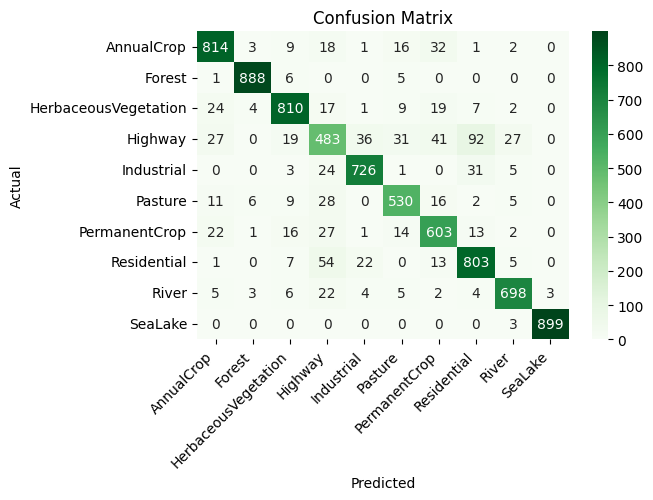

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:\n", conf_matrix)

class_names = sorted(df['Class'].unique())

# Display the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 4))

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.savefig('confusion_matrix_Comb1.png', bbox_inches='tight')
plt.show()

The above confusion matrix helps in understanding the accuracy of each class. Again, Highway and PermanentCrop are classes with low classification accuracy the rest are good.

### Understanding configuration of basic model

In [25]:
print (mlp_basic.n_layers_)
print (mlp_basic.n_iter_)
print (mlp_basic.n_features_in_)

3
200
29


The default number of hidden layers for MLP is (100,). Hence this basic model has 1 hidden, 1 input and 1 output later. The hidden layer has 100 neurons.

The MLP tunes for 200 epochs given by the n_iter.

As we have 29 Input features and 10 Output classes, approximately, we can calculate the for approximate number of hidden layers required from the Nh equation (https://hagan.okstate.edu/NNDesign.pdf#page=469). In the following section, we explore MLP models with approximately 6-8 hidden layers (less than average of input and output layers) with around 200 Neurons.

### Hyper Parameter Optimization

Till now, we have been using only a basic default MLP model. Though this gives good results, we can explore combinations of different parameters to achieve a better result. This requires the use of DASK as the it is highly computationally intensive.

In the following code, we use a random search for hyper parameter tuning on the list of optional parameters.  The parameters tuned are:

- hidden_layer_sizes: This parameter specifies a list of different architectures for the hidden layers of the MLP. Each item in the list is a tuple that indicates the number of neurons in each hidden layer.

- activation: This parameter specifies the activation function to be used in the hidden layers. The options provided are "relu" (Rectified Linear Unit), "logistic" (Sigmoid), and "tanh" (Hyperbolic Tangent).

- alpha: This parameter controls the L2 regularization term used to prevent overfitting.

- batch_size: This parameter defines the minibatch size used during each iteration of training.

In [65]:
from distributed import Client
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
# client

In [42]:
n_features = X.shape[1]

# Define a range of hyperparameter values to search
params = {
        'hidden_layer_sizes': [(36, 36, 36, 36, 36, 36), (24, 24, 24, 24, 24, 24, 24, 24),
                              (36, 24, 36, 24, 36, 24, 36), (48, 48, 48, 48)],
        'activation': ['relu', 'tanh', 'logistic'],
        'alpha': [0.0001, 0.001, 0.01],
        'batch_size': [128, 256, 512],
}

model = MLPClassifier(random_state=121)

n_examples = 4 * len(X_train)
n_params = 8
max_iter = n_params  # number of times partial_fit will be called
chunks = n_examples // n_params  # number of examples each call sees
max_iter, chunks

(8, 9450)

In [40]:
X_train2 = da.from_array(X_train, chunks=chunks)
y_train2 = da.from_array(y_train, chunks=chunks)
X_train2

dask.array<array, shape=(18900, 29), dtype=float64, chunksize=(9450, 29), chunktype=numpy.ndarray>

The longest model will see `n_examples` examples. In this case, it is 2 passes through the dataset. Number of parameters to evaluate in each partial fit is `n_params`.

As seen above the DASK array has two even chunks of 9450 examples each.

A different chunking size is explored later in the script. By splitting the data into dask chunks, we can process the hyper parameter optimization in parallel.

In [41]:
%%time
search = HyperbandSearchCV(
    model,
    params,
    max_iter=max_iter,
    patience=True,
)

print("Number of partial fit calls:", search.metadata["partial_fit_calls"] , "\n \n")

search.fit(X_train2, y_train2, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Number of partial fit calls: 26 
 

CPU times: user 16.4 s, sys: 17.5 s, total: 33.9 s
Wall time: 4.44 s


HyperbandSearchCV(estimator=MLPClassifier(random_state=121), max_iter=8,
                  parameters={'activation': ['relu', 'tanh', 'logistic'],
                              'alpha': [0.0001, 0.001, 0.01],
                              'batch_size': [128, 256, 512],
                              'hidden_layer_sizes': [(36, 36, 36, 36, 36, 36),
                                                     (24, 24, 24, 24, 24, 24,
                                                      24, 24),
                                                     (36, 24, 36, 24, 36, 24,
                                                      36),
                                                     (48, 48, 48, 48)]},
                  patience=True)

The above code runs in less than 5s, without dask this will take over 1.5 hrs. This is due to parallel processing and lazy computing.

In [43]:
# Get the best hyperparameters from the search
best_score = search.best_score_
print("Best accuracy: ", best_score, "\n \n")

best_params = search.best_params_
print("Best Hyperparameters: ", best_params, "\n \n")

Best accuracy:  0.791005291005291 
 

Best Hyperparameters:  {'hidden_layer_sizes': (36, 36, 36, 36, 36, 36), 'batch_size': 128, 'alpha': 0.0001, 'activation': 'relu'} 
 



NOTE: the above accuracy is training accuracy calculated with cv examples. Not to be confused with testing accuracy.

In [50]:
search.predict(X_test)

dask.array<_predict, shape=(8100,), dtype=int64, chunksize=(8100,), chunktype=numpy.ndarray>

In [54]:
hist = pd.DataFrame(search.history_)
hist.shape

(17, 8)

From the history of the search object, we can identify that 17 models were tested to find the best fit.

In [46]:
# Re-train the model with the best hyperparameters
best_mlp_classifier = search.best_estimator_
best_mlp_classifier.fit(X_train, y_train)

# Make predictions using the optimized model
y_pred_optimized = best_mlp_classifier.predict(X_test)

grid_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"Accuracy of 'X' with all features after HPO search: {grid_accuracy:.4f} \n")

Accuracy of 'X' with all features after HPO search: 0.8864 



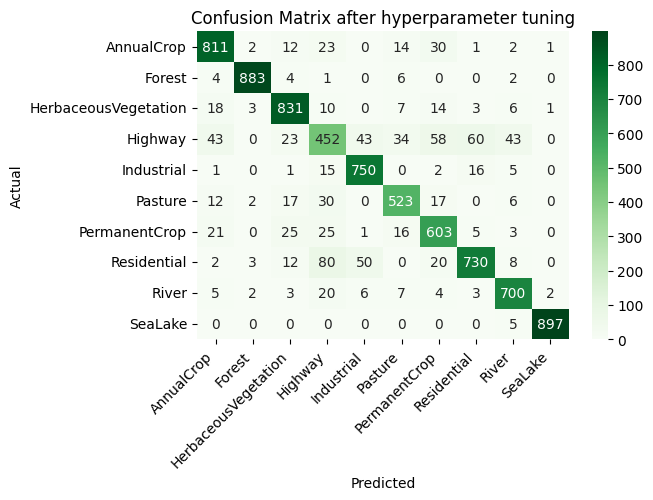

2023-11-06 10:37:19,198 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [48]:
conf_matrix = confusion_matrix(y_test, y_pred_optimized)
# print("Confusion Matrix:\n", conf_matrix)

class_names = sorted(df['Class'].unique())

# Display the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 4))

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix after hyperparameter tuning')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.savefig('confusion_matrix_Comb2.png', bbox_inches='tight')
plt.show()

The best fit MLP model gives an accuracy of 0.8864, slightly less than the MLP_basic tested earlier. This maybe as the new model generalizes the prediction values a bit more.

### Hyper Parameter Optimization with different chunk size

In [66]:
n_features = X.shape[1]

# Define a range of hyperparameter values to search
params = {
        'hidden_layer_sizes': [(36, 36, 36, 36, 36, 36), (24, 24, 24, 24, 24, 24, 24, 24),
                              (36, 24, 36, 24, 36, 24, 36), (48, 48, 48, 48)],
        'activation': ['relu', 'tanh', 'logistic'],
        'alpha': [0.0001, 0.001, 0.01],
        'batch_size': [128, 256, 512],
}

model = MLPClassifier(random_state=121)

n_examples = 2 * len(X_train)
n_params = 8
max_iter = n_params  # number of times partial_fit will be called
chunks = n_examples // n_params  # number of examples each call sees
max_iter, chunks

(8, 4725)

In [67]:
X_train2 = da.from_array(X_train, chunks=chunks)
y_train2 = da.from_array(y_train, chunks=chunks)
X_train2

dask.array<array, shape=(18900, 29), dtype=float64, chunksize=(4725, 29), chunktype=numpy.ndarray>

Here, the `n_examples` has been reduces to 2 times the dataset size. This increases the chunks to 4.

In [68]:
%%time
search = HyperbandSearchCV(
    model,
    params,
    max_iter=max_iter,
    patience=True,
)

print("Number of partial fit calls:", search.metadata["partial_fit_calls"] , "\n \n")

search.fit(X_train2, y_train2, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Number of partial fit calls: 26 
 

CPU times: user 25.6 s, sys: 30.7 s, total: 56.3 s
Wall time: 7.3 s


HyperbandSearchCV(estimator=MLPClassifier(random_state=121), max_iter=8,
                  parameters={'activation': ['relu', 'tanh', 'logistic'],
                              'alpha': [0.0001, 0.001, 0.01],
                              'batch_size': [128, 256, 512],
                              'hidden_layer_sizes': [(36, 36, 36, 36, 36, 36),
                                                     (24, 24, 24, 24, 24, 24,
                                                      24, 24),
                                                     (36, 24, 36, 24, 36, 24,
                                                      36),
                                                     (48, 48, 48, 48)]},
                  patience=True)

In [69]:
# Get the best hyperparameters from the search
best_score = search.best_score_
print("Best accuracy: ", best_score, "\n \n")

best_params = search.best_params_
print("Best Hyperparameters: ", best_params, "\n \n")

# Re-train the model with the best hyperparameters
best_mlp_classifier = search.best_estimator_
best_mlp_classifier.fit(X_train, y_train)

# Make predictions using the optimized model
y_pred_optimized = best_mlp_classifier.predict(X_test)

grid_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"Accuracy of 'X' with all features after HPO search: {grid_accuracy:.4f} \n")

Best accuracy:  0.782010582010582 
 

Best Hyperparameters:  {'hidden_layer_sizes': (48, 48, 48, 48), 'batch_size': 128, 'alpha': 0.001, 'activation': 'tanh'} 
 

Accuracy of 'X' with all features after HPO search: 0.8836 



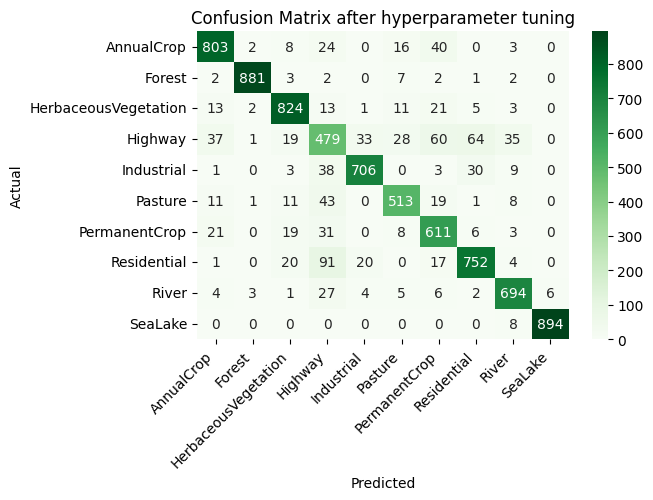

In [70]:
conf_matrix = confusion_matrix(y_test, y_pred_optimized)
# print("Confusion Matrix:\n", conf_matrix)

class_names = sorted(df['Class'].unique())

# Display the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 4))

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix after hyperparameter tuning')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.savefig('confusion_matrix_Comb2.png', bbox_inches='tight')
plt.show()

As observed above, increasing the chunk size, reduced the accuracy of the model. Overall, DASK speeds up HPO to a great extent, but the chunking of the dataset plays a big role in the accuracy of the model. 

In [71]:
client.shutdown()

2023-11-06 10:55:37,567 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
